In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from models import Conv1D, Conv2D, LSTM
from tqdm import tqdm
from glob import glob
import argparse
import warnings
import matplotlib.pyplot as plt
 

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes,
                 batch_size=32, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.wav_paths) / self.batch_size)) #total number of files divided by batch size

    #iter will call __getitem__
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]

        # generate a batch of time data
        X = np.empty((self.batch_size, int(self.sr*self.dt), 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)

        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            rate, wav = wavfile.read(path)
            X[i,] = wav.reshape(-1, 1)
            Y[i,] = to_categorical(label, num_classes=self.n_classes)

        return X, Y


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)


def train(args):
    src_root = args.src_root
    sr = args.sample_rate
    dt = args.delta_time
    batch_size = args.batch_size
    model_type = args.model_type
    params = {'N_CLASSES':len(os.listdir(args.src_root)),
              'SR':sr,
              'DT':dt}
    models = {'conv1d':Conv1D(**params),
              'conv2d':Conv2D(**params),
              'lstm':  LSTM(**params)}
    assert model_type in models.keys(), '{} not an available model'.format(model_type)
    csv_path = os.path.join('logs', '{}_history.csv'.format(model_type))

    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x] #replace the separator symbol to /
    classes = sorted(os.listdir(args.src_root))
    le = LabelEncoder()
    le.fit(classes)
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    labels = le.transform(labels)
    wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
                                                                  labels,
                                                                  test_size=0.1,
                                                                  random_state=0)

    assert len(label_train) >= args.batch_size, 'Number of train samples must be >= batch_size'
    if len(set(label_train)) != params['N_CLASSES']:
        warnings.warn('Found {}/{} classes in training data. Increase data size or change random_state.'.format(len(set(label_train)), params['N_CLASSES']))
    if len(set(label_val)) != params['N_CLASSES']:
        warnings.warn('Found {}/{} classes in validation data. Increase data size or change random_state.'.format(len(set(label_val)), params['N_CLASSES']))

    tg = DataGenerator(wav_train, label_train, sr, dt,
                       params['N_CLASSES'], batch_size=batch_size)
    vg = DataGenerator(wav_val, label_val, sr, dt,
                       params['N_CLASSES'], batch_size=batch_size)
    
    
    #model = models[model_type]
    #model.summary()

    #'''
    model = models[model_type]
    model.summary()
    cp = ModelCheckpoint('models/{}.h5'.format(model_type), monitor='val_loss',
                         save_best_only=True, save_weights_only=False,
                         mode='auto', save_freq='epoch', verbose=1)
    csv_logger = CSVLogger(csv_path, append=False)
    hist = model.fit(tg, validation_data=vg,
              epochs=100, verbose=1,
              callbacks=[csv_logger, cp])
    #'''
    return hist

if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Training')
    parser.add_argument('--model_type', type=str, default='conv2d',
                        help='model to run. i.e. conv1d, conv2d, lstm')
    parser.add_argument('--src_root', type=str, default='D:/SirenNeuralNetwork/enhanced-sirenmodel/clean',
                        help='directory of audio files in total duration')
    parser.add_argument('--batch_size', type=int, default=16,
                        help='batch size')
    parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sample_rate', '-sr', type=int, default=16000,
                        help='sample rate of clean audio')
    args, _ = parser.parse_known_args()

    hist = train(args)

# python train.py

Model: "2d_convolution"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stft_1_input (InputLayer)   [(None, 16000, 1)]        0         
                                                                 
 stft_1 (STFT)               (None, 100, 257, 1)       0         
                                                                 
 magnitude_1 (Magnitude)     (None, 100, 257, 1)       0         
                                                                 
 apply_filterbank_1 (ApplyFi  (None, 100, 128, 1)      0         
 lterbank)                                                       
                                                                 
 magnitude_to_decibel_1 (Mag  (None, 100, 128, 1)      0         
 nitudeToDecibel)                                                
                                                                 
 batch_norm (LayerNormalizat  (None, 100, 128, 1)   

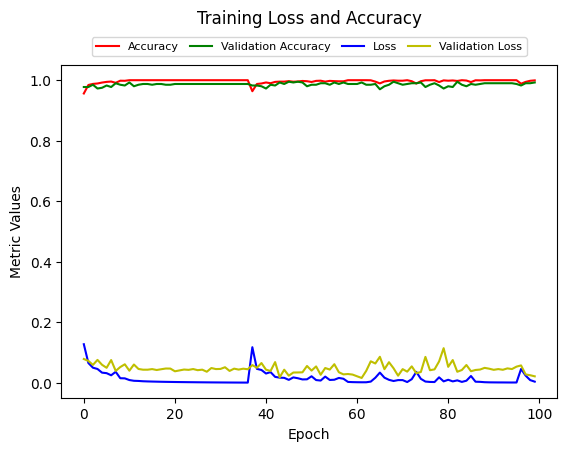

In [10]:
fig, ax = plt.subplots()
ax.plot(hist.history['accuracy'], 'r', label='Accuracy')
ax.plot(hist.history['val_accuracy'], 'g', label='Validation Accuracy')
ax.plot(hist.history['loss'], 'b', label='Loss')
ax.plot(hist.history['val_loss'], 'y', label='Validation Loss')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(.5,1.1), ncols=4, fontsize=8, columnspacing=1)
ax.set_title('Training Loss and Accuracy', pad=30)
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric Values')

plt.show()

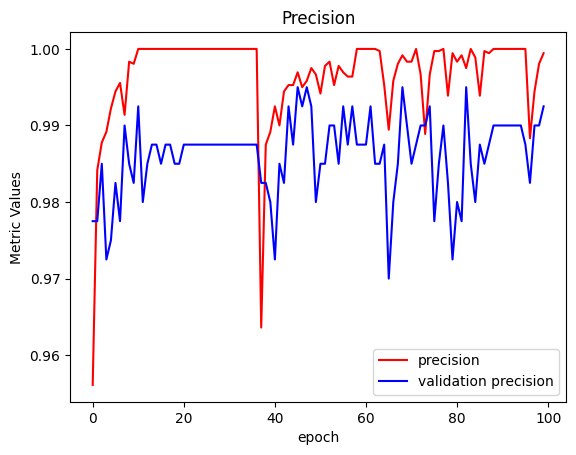

In [11]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r', label='precision')
plt.plot(hist.history['val_precision_1'], 'b', label='validation precision')
plt.xlabel("epoch")
plt.ylabel("Metric Values")
plt.legend()
plt.show()

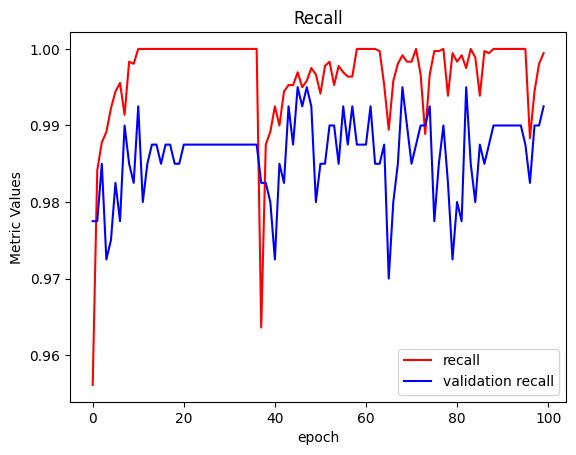

In [12]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r', label='recall')
plt.plot(hist.history['val_recall_1'], 'b', label='validation recall')
plt.xlabel("epoch")
plt.ylabel("Metric Values")
plt.legend()
plt.show()

# RJKHASDKASH


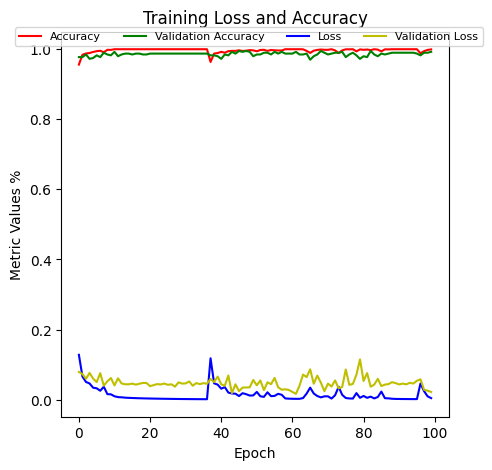

In [3]:
plt.figure(figsize=(5,5))
plt.title('Training Loss and Accuracy')
plt.plot(hist.history['accuracy'], 'r', label='Accuracy')
plt.plot(hist.history['val_accuracy'], 'g', label='Validation Accuracy')
plt.plot(hist.history['loss'], 'b', label='Loss')
plt.plot(hist.history['val_loss'], 'y', label='Validation Loss')
plt.figlegend(loc='upper center', ncols=4, bbox_to_anchor=(.5,.9), fontsize=8, fancybox=True)
plt.xlabel('Epoch')
plt.ylabel('Metric Values %')
plt.show()

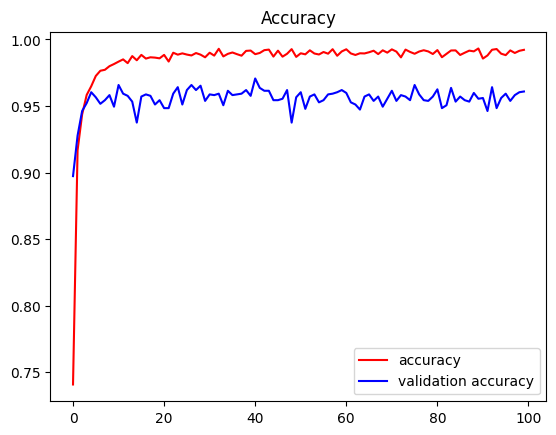

In [4]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label='validation accuracy')
plt.legend()
plt.show()


NameError: name 'hist' is not defined

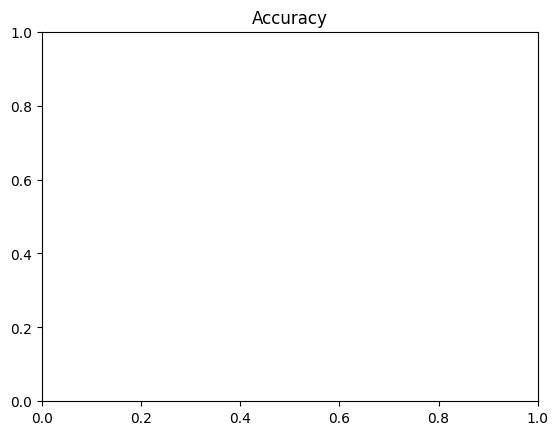

In [5]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label='validation accuracy')
plt.legend()
plt.show()

plt.title('Loss')
plt.plot(hist.history['loss'], 'r', label='loss')
plt.plot(hist.history['val_loss'], 'b', label='validation loss')
plt.show()

plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label='precision')
plt.plot(hist.history['val_precision'], 'b', label='validation precision')
plt.legend()
plt.show()

plt.title('Recall')
plt.plot(hist.history['recall'], 'r', label='recall')
plt.plot(hist.history['val_recall'], 'b', label='validation recall')
plt.legend()
plt.show()